<a href="https://colab.research.google.com/github/ninja-marduk/ml_precipitation_prediction/blob/main/models/base_models_STHyMOUNTAIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📘 Entrenamiento de Modelos Baseline para Predicción Espaciotemporal de Precipitación Mensual STHyMOUNTAIN

Este notebook implementa modelos baseline para la predicción de precipitaciones usando datos espaciotemporales.

## 🔍 Implementación de Modelos Avanzados y Técnicas de Validación

Además de los modelos tabulares baseline, implementaremos:

1. **Optimización avanzada con Optuna** para los modelos tabulares XGBoost y LightGBM
2. **Validación robusta** mediante:
   - Hold-Out Validation (ya implementada)
   - Cross-Validation (k=5)
   - Bootstrapping (100 muestras)
3. **Modelos de Deep Learning** para capturar patrones espaciales y temporales:
   - Redes CNN para patrones espaciales
   - Redes ConvLSTM para patrones espaciotemporales

El objetivo es proporcionar una evaluación completa de diferentes enfoques de modelado para la predicción de precipitación en regiones montañosas.

In [51]:
# Configuración del entorno (compatible con Colab y local)
import os
import sys
from pathlib import Path
import shutil
import time
import psutil

# Detectar si estamos en Google Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')   
    # Si estamos en Colab, clonar el repositorio
    !git clone https://github.com/ninja-marduk/ml_precipitation_prediction.git
    %cd ml_precipitation_prediction
    # Instalar dependencias necesarias
    !pip install -r requirements.txt
    !pip install xarray netCDF4 optuna matplotlib seaborn lightgbm xgboost scikit-learn
    BASE_PATH = '/content/drive/MyDrive/ml_precipitation_prediction'
else:
    # Si estamos en local, usar la ruta actual
    if '/models' in os.getcwd():
        BASE_PATH = Path('..')
    else:
        BASE_PATH = Path('.')

print(f"Entorno configurado. Usando ruta base: {BASE_PATH}")

# Si BASE_PATH viene como string, lo convertimos
BASE_PATH = Path(BASE_PATH)

# Ahora puedes concatenar correctamente
model_output_dir = BASE_PATH / 'models' / 'output'
model_output_dir.mkdir(parents=True, exist_ok=True)

print(f"Directorio para salida de modelos creado: {model_output_dir}")

# Implementación de resiliencia para interacción con Google Drive y restauración de datos
def backup_dataframe(df, backup_path):
    """Guarda un DataFrame como respaldo en formato Parquet."""
    try:
        df.to_parquet(backup_path, index=False)
        print(f"Respaldo del DataFrame guardado en: {backup_path}")
    except Exception as e:
        print(f"Error al guardar respaldo del DataFrame: {e}")

def restore_dataframe(backup_path):
    """Restaura un DataFrame desde un archivo de respaldo en formato Parquet."""
    try:
        if backup_path.exists():
            df_restored = pd.read_parquet(backup_path)
            print(f"DataFrame restaurado desde: {backup_path}")
            return df_restored
        else:
            print(f"No se encontró el archivo de respaldo en: {backup_path}")
            return None
    except Exception as e:
        print(f"Error al restaurar el DataFrame: {e}")
        return None

# Ruta para respaldo temporal del DataFrame
temp_dir = BASE_PATH / 'data' / 'output' / 'temp'
temp_dir.mkdir(parents=True, exist_ok=True)
temp_file_path = temp_dir / 'dataframe_backup.parquet'

# Respaldo inicial del DataFrame principal
if 'df' in locals() and df is not None:
    backup_dataframe(df, temp_file_path)

# Modificar interacción con Google Drive para reintentos
max_retries = 3
retry_delay = 5  # segundos

def mount_google_drive():
    """Intenta montar Google Drive con reintentos."""
    for attempt in range(max_retries):
        try:
            from google.colab import drive
            drive.mount('/content/drive')
            print("Google Drive montado exitosamente.")
            return True
        except Exception as e:
            print(f"Error al montar Google Drive (intento {attempt + 1}/{max_retries}): {e}")
            if attempt < max_retries - 1:
                time.sleep(retry_delay)
    print("No se pudo montar Google Drive después de varios intentos.")
    return False

if IN_COLAB:
    if not mount_google_drive():
        print("Usando datos en memoria o restaurando desde respaldo local.")
        df = restore_dataframe(temp_file_path)

# Restaurar modelos guardados en caso de fallo
model_files = {
    'RandomForest': model_output_dir / 'RandomForest.pkl',
    'XGBoost': model_output_dir / 'XGBoost.pkl',
    'LightGBM': model_output_dir / 'LightGBM.pkl'
}

def load_saved_model(model_name, model_path):
    """Carga un modelo guardado desde disco."""
    try:
        with open(model_path, 'rb') as f:
            model = pickle.load(f)
            print(f"Modelo {model_name} cargado desde: {model_path}")
            return model
    except Exception as e:
        print(f"Error al cargar el modelo {model_name}: {e}")
        return None

# Inicializar `modelos_base` como un diccionario vacío
modelos_base = {}

# Intentar cargar modelos guardados
for model_name, model_path in model_files.items():
    if model_name not in modelos_base:
        modelos_base[model_name] = load_saved_model(model_name, model_path)

# Implementación de resiliencia para modelos CNN y ConvLSTM

# Respaldo y restauración de modelos CNN y ConvLSTM
cnn_model_path = model_output_dir / 'cnn_model.h5'
convlstm_model_path = model_output_dir / 'convlstm_model.h5'

def backup_model(model, model_path):
    """Guarda un modelo de Keras como respaldo."""
    try:
        model.save(model_path)
        print(f"Modelo respaldado en: {model_path}")
    except Exception as e:
        print(f"Error al guardar respaldo del modelo: {e}")

def restore_model(model_path):
    """Restaura un modelo de Keras desde un archivo de respaldo."""
    try:
        if model_path.exists():
            model = tf.keras.models.load_model(model_path)
            print(f"Modelo restaurado desde: {model_path}")
            return model
        else:
            print(f"No se encontró el archivo de respaldo en: {model_path}")
            return None
    except Exception as e:
        print(f"Error al restaurar el modelo: {e}")
        return None

# Respaldo inicial de modelos si existen
if 'cnn_model' in locals() and cnn_model is not None:
    backup_model(cnn_model, cnn_model_path)
if 'convlstm_model' in locals() and convlstm_model is not None:
    backup_model(convlstm_model, convlstm_model_path)

# Restaurar modelos en caso de fallo
if 'cnn_model' not in locals() or cnn_model is None:
    cnn_model = restore_model(cnn_model_path)
if 'convlstm_model' not in locals() or convlstm_model is None:
    convlstm_model = restore_model(convlstm_model_path)

# Modificar interacción con Google Drive para reintentos
max_retries = 3
retry_delay = 5  # segundos

def mount_google_drive():
    """Intenta montar Google Drive con reintentos."""
    for attempt in range(max_retries):
        try:
            from google.colab import drive
            drive.mount('/content/drive')
            print("Google Drive montado exitosamente.")
            return True
        except Exception as e:
            print(f"Error al montar Google Drive (intento {attempt + 1}/{max_retries}): {e}")
            if attempt < max_retries - 1:
                time.sleep(retry_delay)
    print("No se pudo montar Google Drive después de varios intentos.")
    return False

if IN_COLAB:
    if not mount_google_drive():
        print("Usando datos en memoria o restaurando desde respaldo local para modelos CNN y ConvLSTM.")

Entorno configurado. Usando ruta base: ..
Directorio para salida de modelos creado: ../models/output
Respaldo del DataFrame guardado en: ../data/output/temp/dataframe_backup.parquet
Modelo RandomForest cargado desde: ../models/output/RandomForest.pkl
Modelo XGBoost cargado desde: ../models/output/XGBoost.pkl
Modelo LightGBM cargado desde: ../models/output/LightGBM.pkl
No se encontró el archivo de respaldo en: ../models/output/cnn_model.h5
No se encontró el archivo de respaldo en: ../models/output/convlstm_model.h5


In [52]:
# 1. Importaciones necesarias
import numpy as np
import pandas as pd
import xarray as xr
import optuna
import pickle
import datetime
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Importaciones para barras de progreso y mejora de visualización
from tqdm.notebook import tqdm, trange
from IPython.display import display, HTML, clear_output
import time

# Configurar visualización más atractiva
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [53]:
# Importaciones adicionales para Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, save_model, load_model
from tensorflow.keras.layers import (Dense, Dropout, Conv2D, Conv3D, ConvLSTM2D, BatchNormalization, 
                                   MaxPooling2D, Flatten, Input, concatenate, Reshape, TimeDistributed, UpSampling2D)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

print("TensorFlow versión:", tf.__version__)

# Configurar GPU si está disponible
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    print(f"GPU disponible: {physical_devices}")
    # Permitir crecimiento de memoria según sea necesario
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    print("No se detectó GPU. Usando CPU.")

TensorFlow versión: 2.18.0
No se detectó GPU. Usando CPU.


In [54]:
# 2. Cargar el dataset NetCDF
def load_dataset(file_path):
    """Carga un archivo NetCDF y lo convierte a pandas DataFrame"""
    try:
        # Cargar el archivo NetCDF con xarray
        print(f"Intentando cargar el archivo: {file_path}")
        ds = xr.open_dataset(file_path)
        print("Archivo cargado exitosamente con xarray")

        # Mostrar información del dataset cargado
        print("\nInformación del dataset:")
        print(ds.info())
        print("\nVariables disponibles:")
        for var_name in ds.data_vars:
            print(f"- {var_name}: {ds[var_name].shape}")

        # Convertir a DataFrame
        df = ds.to_dataframe().reset_index()
        return df, ds
    except Exception as e:
        print(f"Error al cargar el archivo NetCDF: {e}")
        return None, None

# Ruta al dataset
data_file_path = BASE_PATH / 'data' / 'output'
data_file = BASE_PATH / 'data' / 'output' / 'complete_dataset_with_features.nc'
print(f"Buscando archivo en: {data_file}")

# Cargar el dataset
df, ds_original = load_dataset(data_file)

# Verificar si se cargó correctamente
if df is not None:
    print(f"Dataset cargado con éxito. Dimensiones: {df.shape}")
    print("\nPrimeras filas del DataFrame:")
    display(df.head())
else:
    print("No se pudo cargar el dataset. Verificar la ruta y el formato del archivo.")

Buscando archivo en: ../data/output/complete_dataset_with_features.nc
Intentando cargar el archivo: ../data/output/complete_dataset_with_features.nc
Archivo cargado exitosamente con xarray

Información del dataset:
xarray.Dataset {
dimensions:
	time = 530 ;
	latitude = 62 ;
	longitude = 66 ;

variables:
	datetime64[ns] time(time) ;
	float32 latitude(latitude) ;
	float32 longitude(longitude) ;
	float32 total_precipitation(time, latitude, longitude) ;
	float32 max_daily_precipitation(time, latitude, longitude) ;
	float32 min_daily_precipitation(time, latitude, longitude) ;
	float32 daily_precipitation_std(time, latitude, longitude) ;
	float32 month_sin(time, latitude, longitude) ;
	float32 month_cos(time, latitude, longitude) ;
	float32 doy_sin(time, latitude, longitude) ;
	float32 doy_cos(time, latitude, longitude) ;
	float64 elevation(latitude, longitude) ;
	float32 slope(latitude, longitude) ;
	float32 aspect(latitude, longitude) ;

// global attributes:
	:description = ST-HyMOUNTAIN-

,time,latitude,longitude,total_precipitation,max_daily_precipitation,min_daily_precipitation,daily_precipitation_std,month_sin,month_cos,doy_sin,doy_cos,elevation,slope,aspect
0,1981-01-01,4.324997,-74.975006,47.381050,24.706928,0.0,5.825776,0.5,0.866025,0.017202,0.999852,493.784552,89.539551,102.044502
1,1981-01-01,4.324997,-74.925003,40.750824,21.819195,0.0,5.019045,0.5,0.866025,0.017202,0.999852,519.750107,89.867020,73.481674
2,1981-01-01,4.324997,-74.875008,46.338623,26.092327,0.0,5.740223,0.5,0.866025,0.017202,0.999852,248.776045,89.722221,65.916817
3,1981-01-01,4.324997,-74.825005,48.779938,29.421450,0.0,5.611738,0.5,0.866025,0.017202,0.999852,351.415728,86.986130,140.916000
4,1981-01-01,4.324997,-74.775002,38.932945,18.483061,0.0,3.733574,0.5,0.866025,0.017202,0.999852,278.261922,88.273293,18.439939


In [55]:
# 3. Preparación de los datos
if df is not None:
    # Identificar la columna objetivo (precipitación)
    target_column = 'total_precipitation'  # Ajustar si tiene otro nombre en tu dataset

    # Ver si existe 'precip_target' o usar 'total_precipitation'
    if 'total_precipitation' in df.columns:
        target_column = 'total_precipitation'

    print(f"Columna objetivo identificada: {target_column}")

    # Separar variables predictoras y variable objetivo
    feature_cols = [col for col in df.columns if col != target_column and not pd.isna(df[col]).all()]

    # Eliminar columnas no numéricas para los modelos (como fechas o coordenadas si no se usan como features)
    non_feature_cols = ['time', 'spatial_ref']
    feature_cols = [col for col in feature_cols if col not in non_feature_cols]

    # Eliminar filas con valores NaN
    print(f"Filas antes de eliminar NaN: {df.shape[0]}")
    df_clean = df.dropna(subset=[target_column] + feature_cols)
    print(f"Filas después de eliminar NaN: {df_clean.shape[0]}")

    # Separar features y target
    X = df_clean[feature_cols]
    y = df_clean[target_column]

    print(f"\nFeatures seleccionadas ({len(feature_cols)}):\n{feature_cols}")
    print(f"\nVariable objetivo: {target_column}")

Columna objetivo identificada: total_precipitation
Filas antes de eliminar NaN: 2168760
Filas después de eliminar NaN: 2168760

Features seleccionadas (12):
['latitude', 'longitude', 'max_daily_precipitation', 'min_daily_precipitation', 'daily_precipitation_std', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos', 'elevation', 'slope', 'aspect']

Variable objetivo: total_precipitation


In [56]:
# 4. División del conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Dimensiones del conjunto de entrenamiento: {X_train.shape}")
print(f"Dimensiones del conjunto de prueba: {X_test.shape}")

# 5. Estandarización de variables predictoras
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Guardar el scaler para uso futuro
with open(model_output_dir / 'scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Escalador guardado en models/output/scaler.pkl")

Dimensiones del conjunto de entrenamiento: (1735008, 12)
Dimensiones del conjunto de prueba: (433752, 12)
Escalador guardado en models/output/scaler.pkl


In [57]:
# 6. Funciones de evaluación y entrenamiento
def evaluar_modelo(y_true, y_pred):
    """Evalúa el rendimiento de un modelo usando múltiples métricas"""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return rmse, mae, r2

def entrenar_y_evaluar_modelo(modelo, nombre, X_train, y_train, X_test, y_test):
    """Entrena un modelo y evalúa su rendimiento con visualización del progreso"""
    # Crear widget para mostrar información del proceso
    display(HTML(f'<div style="background-color:#f0f8ff; padding:10px; border-radius:5px;">' +
                 f'<h3>🔄 Entrenando modelo: {nombre}</h3>' +
                 f'<div id="status_{nombre}">Estado: Iniciando entrenamiento...</div>' +
                 f'</div>'))
    
    # Tiempo de inicio
    start_time = time.time()
    
    # Entrenar el modelo con seguimiento visual según el tipo
    if hasattr(modelo, 'fit_generator') or nombre in ['XGBoost', 'XGBoost_Optuna', 'LightGBM', 'LightGBM_Optuna']:
        # Para modelos que soportan entrenamiento por lotes como XGBoost, LightGBM
        print(f"Entrenando {nombre} con visualización de progreso...")
        if hasattr(modelo, 'n_estimators'):
            n_estimators = modelo.n_estimators
            for i in tqdm(range(n_estimators), desc=f"Entrenando {nombre}"):
                if i == 0:
                    # Primera iteración, ajuste inicial
                    if nombre.startswith('LightGBM'):
                        # LightGBM tiene parámetro verbose
                        temp_modelo = type(modelo)(n_estimators=1, **{k:v for k,v in modelo.get_params().items() 
                                                                 if k != 'n_estimators' and k != 'verbose'}, verbose=-1)
                    else:
                        temp_modelo = type(modelo)(n_estimators=1, **{k:v for k,v in modelo.get_params().items() 
                                                                if k != 'n_estimators'})
                    temp_modelo.fit(X_train, y_train)
                elif i == n_estimators - 1:
                    # Última iteración, ajuste completo
                    modelo.fit(X_train, y_train)
                
                # Actualizar progreso visual
                if i % max(1, n_estimators // 10) == 0:
                    clear_output(wait=True)
                    display(HTML(f'<div style="background-color:#f0f8ff; padding:10px; border-radius:5px;">' +
                                f'<h3>🔄 Entrenando modelo: {nombre}</h3>' +
                                f'<div id="status_{nombre}">Estado: Progreso {i+1}/{n_estimators} estimadores ({((i+1)/n_estimators*100):.1f}%)</div>' +
                                f'</div>'))
                    time.sleep(0.1)  # Pequeña pausa para actualización visual
        else:
            # Si no tiene n_estimators, entrenamiento directo
            modelo.fit(X_train, y_train)
    else:
        # Para modelos estándar como RandomForest
        modelo.fit(X_train, y_train)
    
    # Tiempo de entrenamiento
    training_time = time.time() - start_time
    
    # Visualizar tiempo de entrenamiento
    display(HTML(f'<div style="background-color:#e6ffe6; padding:10px; border-radius:5px;">' +
                f'<h3>✅ Entrenamiento completado: {nombre}</h3>' +
                f'<div>Tiempo de entrenamiento: {training_time:.2f} segundos</div>' +
                f'</div>'))
    
    print(f"Evaluando rendimiento de {nombre}...")
    predicciones = modelo.predict(X_test)
    rmse, mae, r2 = evaluar_modelo(y_test, predicciones)
    
    # Visualizar métricas con estilo
    display(HTML(f'<div style="background-color:#f5f5dc; padding:10px; border-radius:5px; margin-top:10px;">' +
                f'<h3>📊 Métricas para {nombre}</h3>' +
                f'<table style="width:100%; text-align:left;">' +
                f'<tr><th>Métrica</th><th>Valor</th></tr>' +
                f'<tr><td>RMSE</td><td>{rmse:.4f}</td></tr>' +
                f'<tr><td>MAE</td><td>{mae:.4f}</td></tr>' +
                f'<tr><td>R²</td><td>{r2:.4f}</td></tr>' +
                f'</table></div>'))
    
    return modelo, (rmse, mae, r2)

def guardar_modelo(modelo, nombre):
    """Guarda un modelo entrenado en disco"""
    # timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    # filename = f"{nombre}_{timestamp}.pkl"
    filename = f"{nombre}.pkl"
    with open(model_output_dir / filename, 'wb') as f:
        pickle.dump(modelo, f)
    
    # Visualizar confirmación de guardado
    display(HTML(f'<div style="background-color:#e6ffee; padding:10px; border-radius:5px; margin-top:10px;">' +
                f'<h3>💾 Modelo guardado</h3>' +
                f'<div>Modelo <b>{nombre}</b> guardado como: {filename}</div>' +
                f'</div>'))
    return filename

Modelo RandomForest encontrado en ../models/output/RandomForest.pkl. Cargando...
Evaluando modelo RandomForest...
✅ RandomForest evaluado: RMSE=36.4174, MAE=24.8917, MAPE=57123879814.4743, Acc=-57123879813.4743, R2=0.9168
Modelo XGBoost encontrado en ../models/output/XGBoost.pkl. Cargando...
Evaluando modelo XGBoost...
✅ XGBoost evaluado: RMSE=37.8542, MAE=26.3499, MAPE=36435415531520.0000, Acc=-36435415531519.0000, R2=0.9101
Modelo LightGBM encontrado en ../models/output/LightGBM.pkl. Cargando...
Evaluando modelo LightGBM...
✅ LightGBM evaluado: RMSE=39.0589, MAE=27.3338, MAPE=64468897807520.6016, Acc=-64468897807519.6016, R2=0.9043

🔍 Comparación de modelos base sin optimización:

Tabla de métricas:


,RMSE,MAE,MAPE,Acc,R2
RandomForest,36.417363,24.891715,5.712388e+10,-5.712388e+10,0.916798
XGBoost,37.854203,26.349937,3.643542e+13,-3.643542e+13,0.910103
LightGBM,39.058929,27.333847,6.446890e+13,-6.446890e+13,0.904290



Ordenados por RMSE (menor es mejor):


,RMSE,MAE,MAPE,Acc,R2
RandomForest,36.417363,24.891715,5.712388e+10,-5.712388e+10,0.916798
XGBoost,37.854203,26.349937,3.643542e+13,-3.643542e+13,0.910103
LightGBM,39.058929,27.333847,6.446890e+13,-6.446890e+13,0.904290


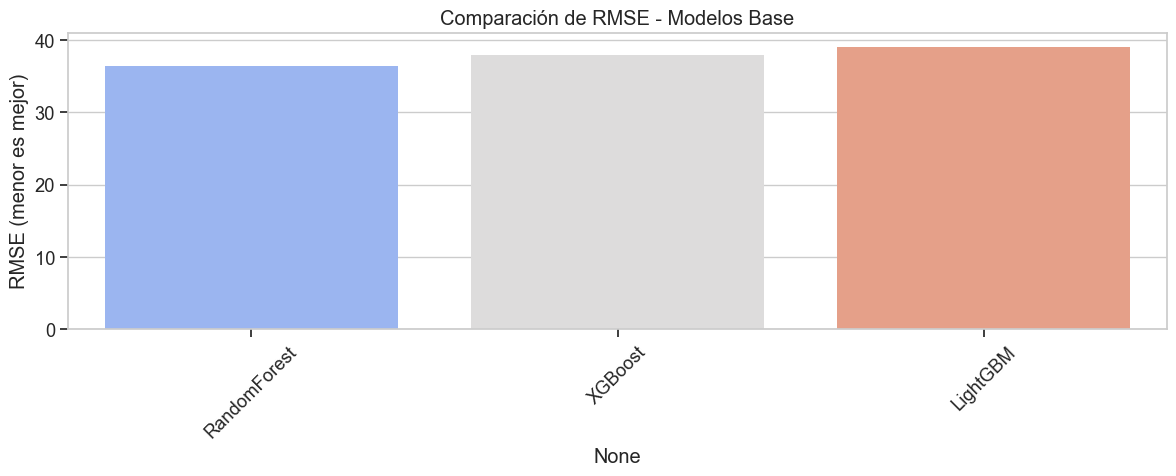

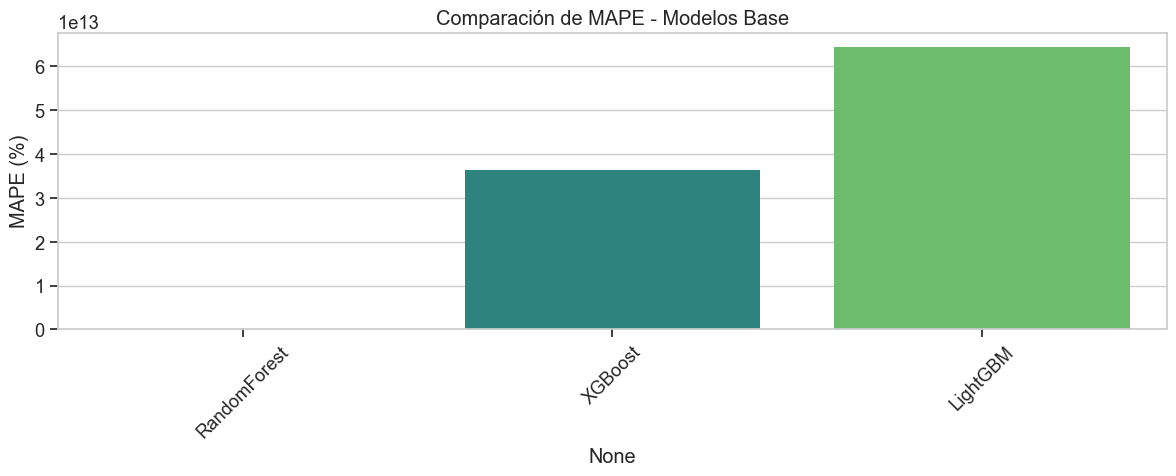

In [58]:
# 🔁 1. Importaciones necesarias
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    mean_absolute_percentage_error
)
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import tensorflow as tf
from pathlib import Path

# ⚙️ 2. Diccionarios de almacenamiento
resultados_base = {}
modelos_base = {}
modelos_guardados = {}

# 📁 3. Rutas de modelos guardados
model_paths = {
    'RandomForest': model_output_dir / 'RandomForest.pkl',
    'XGBoost':     model_output_dir / 'XGBoost.pkl',
    'LightGBM':    model_output_dir / 'LightGBM.pkl'
}

# ✅ 4. Carga y evaluación de modelos estándar o entrenamiento si no existen
for model_name, model_path in model_paths.items():
    # Cargar o entrenar
    if model_path.exists():
        print(f"Modelo {model_name} encontrado en {model_path}. Cargando...")
        with open(model_path, 'rb') as f:
            modelo = pickle.load(f)
    else:
        print(f"Modelo {model_name} no encontrado. Entrenando desde cero...")
        if model_name == 'RandomForest':
            modelo = RandomForestRegressor(n_estimators=100, random_state=42)
        elif model_name == 'XGBoost':
            modelo = XGBRegressor(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='rmse')
        elif model_name == 'LightGBM':
            modelo = LGBMRegressor(n_estimators=100, random_state=42)
        modelo.fit(X_train_scaled, y_train)
        with open(model_path, 'wb') as f:
            pickle.dump(modelo, f)
        print(f"Modelo {model_name} entrenado y guardado en {model_path}.")
    modelos_base[model_name] = modelo

    # Evaluar el modelo
    print(f"Evaluando modelo {model_name}...")
    y_pred = modelo.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    acc  = 1 - mape
    r2   = r2_score(y_test, y_pred)

    resultados_base[model_name] = {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'Acc': acc,
        'R2': r2
    }
    print(f"✅ {model_name} evaluado: RMSE={rmse:.4f}, MAE={mae:.4f}, MAPE={mape:.4f}, Acc={acc:.4f}, R2={r2:.4f}")

# 📊 5. Visualización de resultados
print("\n🔍 Comparación de modelos base sin optimización:")
temp_df = pd.DataFrame(resultados_base).T
# Reordenar columnas
cols = ['RMSE','MAE','MAPE','Acc','R2']
temp_df = temp_df[cols]

print("\nTabla de métricas:")
display(temp_df)

# Ordenados por RMSE
df_sorted = temp_df.sort_values('RMSE')
print("\nOrdenados por RMSE (menor es mejor):")
display(df_sorted)

# Gráficos comparativos
plt.figure(figsize=(12, 5))
sns.barplot(x=df_sorted.index, y=df_sorted['RMSE'], palette='coolwarm')
plt.title('Comparación de RMSE - Modelos Base')
plt.ylabel('RMSE (menor es mejor)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(model_output_dir / 'baseline_rmse_comparison_full.png')
plt.show()

plt.figure(figsize=(12, 5))
sns.barplot(x=df_sorted.index, y=df_sorted['MAPE'], palette='viridis')
plt.title('Comparación de MAPE - Modelos Base')
plt.ylabel('MAPE (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(model_output_dir / 'baseline_mape_comparison_full.png')
plt.show()


📊 Iniciando optimización adaptativa para RandomForest...
🔄 Modelo optimizado RandomForest encontrado en ../models/output/RandomForest_optimized.pkl. Cargando y evaluando...
✅ RandomForest cargado y evaluado:
   MAE = 29.3788, RMSE = 41.7221, MAPE = 31492656809349.4609, Acc = -31492656809348.4609, R² = 0.8908



📊 Iniciando optimización adaptativa para XGBoost...
🔄 Modelo optimizado XGBoost encontrado en ../models/output/XGBoost_optimized.pkl. Cargando y evaluando...
✅ XGBoost cargado y evaluado:
   MAE = 24.6920, RMSE = 35.9326, MAPE = 32206703558656.0000, Acc = -32206703558655.0000, R² = 0.9190



📊 Iniciando optimización adaptativa para LightGBM...
🔄 Modelo optimizado LightGBM encontrado en ../models/output/LightGBM_optimized.pkl. Cargando y evaluando...
✅ LightGBM cargado y evaluado:
   MAE = 26.2708, RMSE = 37.7595, MAPE = 28269707542875.7305, Acc = -28269707542874.7305, R² = 0.9106



📊 Comparative metrics for all models:


,MAE,RMSE,MAPE,Acc,R2
RandomForest,29.378786,41.722129,3.149266e+13,-3.149266e+13,0.890793
XGBoost,24.691959,35.932564,3.220670e+13,-3.220670e+13,0.918998
LightGBM,26.270816,37.759494,2.826971e+13,-2.826971e+13,0.910552


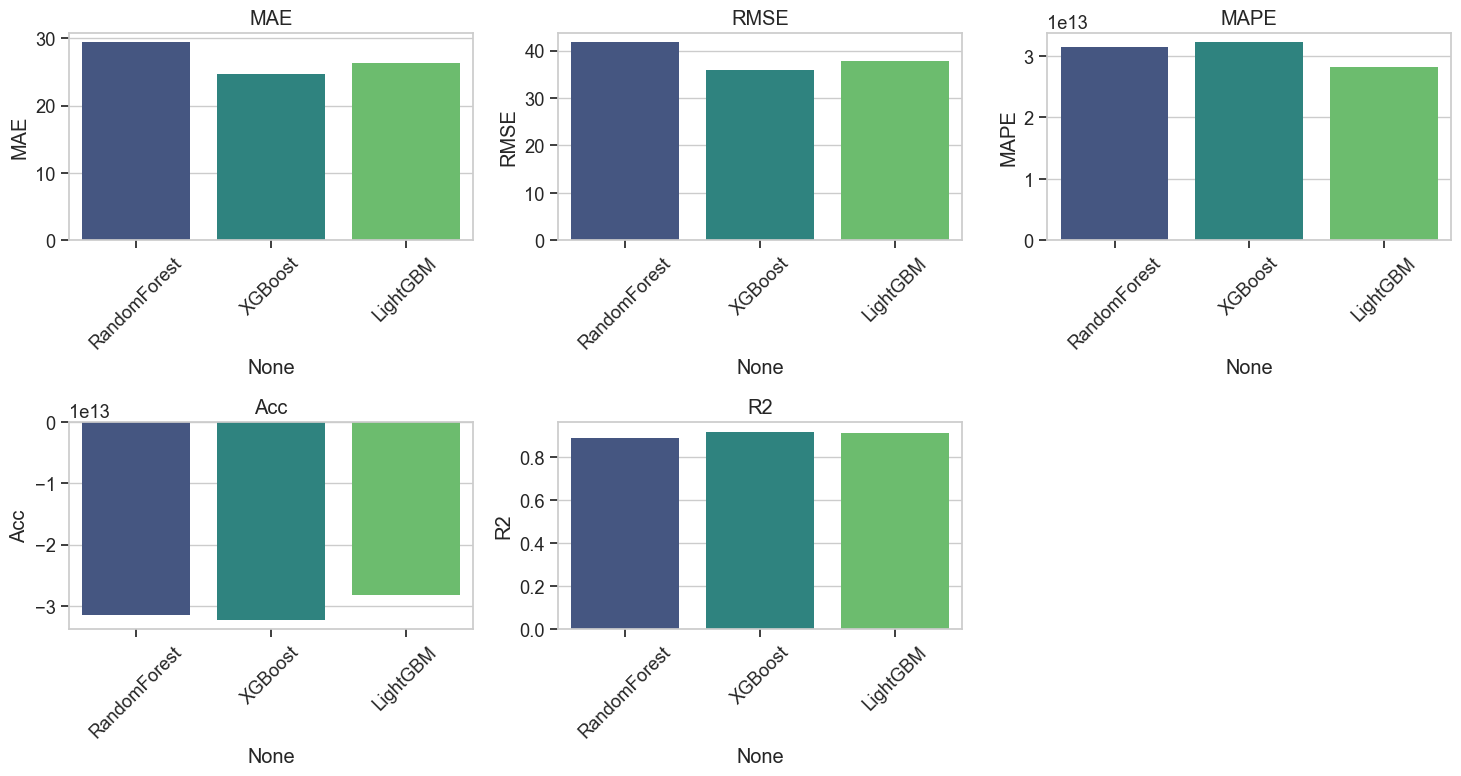

In [61]:
# ✅ Versión robusta optimizada con control de memoria para Colab y local

import os
import gc
import psutil
import warnings
import pickle
import optuna
import numpy as np
import pandas as pd
from pathlib import Path
from sqlalchemy.exc import OperationalError
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    mean_absolute_percentage_error
)
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from IPython.display import display, HTML

# Funciones de visualización de status
def display_training_status(model_name, status):
    display(HTML(f'<div style="background-color:#f0f8ff; padding:10px; border-radius:5px;">' +
                 f'<h3>🔄 Entrenando modelo: {model_name}</h3>' +
                 f'<div>Estado: {status}</div>' +
                 f'</div>'))

def handle_training_error(model_name, error):
    display(HTML(f'<div style="background-color:#ffe6e6; padding:10px; border-radius:5px;">' +
                 f'<h3>❌ Error en modelo: {model_name}</h3>' +
                 f'<div>Error: {error}</div>' +
                 f'</div>'))

resultados_base = {}
model_paths = {}

# Detectar entorno Colab
def is_running_in_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

# Validar memoria mínima disponible
def check_memory(threshold_gb=0.5):
    available = psutil.virtual_memory().available / (1024 ** 3)
    if available < threshold_gb:
        raise MemoryError(f"🚫 Memoria RAM insuficiente (< {threshold_gb:.2f} GB disponibles)")

# Supresión de warnings XGBoost
def suppress_specific_warnings():
    warnings.filterwarnings("ignore", category=UserWarning, module="xgboost")
    os.environ["XGBOOST_DISABLE_USE_LABEL_ENCODER"] = "1"

suppress_specific_warnings()

# Validar ruta de base de datos
def validate_database_path(db_path):
    try:
        with open(db_path, 'a'):
            pass
        return db_path
    except IOError:
        return ':memory:'

# Callback de progreso
class OptimizationProgressCallback:
    def __init__(self, total_trials, model_name="Modelo"):
        self.total_trials = total_trials
        self.model_name = model_name
    def __call__(self, study, trial):
        completed = len(study.trials)
        if completed % 5 == 0 or completed == self.total_trials:
            print(f"📈 [{self.model_name}] Trials completados: {completed}/{self.total_trials}")

# Función de optimización adaptativa
# … (importaciones y funciones auxiliares quedan igual) …

def run_memory_efficient_optimization(model_type, X_train, y_train, X_test, y_test):
    print(f"\n📊 Iniciando optimización adaptativa para {model_type}...")
    gc.collect()
    model_file = model_output_dir / f"{model_type}_optimized.pkl"

    # — Si ya existe, cargar + evaluar —
    if model_file.exists():
        print(f"🔄 Modelo optimizado {model_type} encontrado en {model_file}. Cargando y evaluando...")
        with open(model_file, 'rb') as f:
            best_model = pickle.load(f)

        # Predecir y computar métricas
        y_pred = best_model.predict(X_test)
        mae   = mean_absolute_error(y_test, y_pred)
        rmse  = np.sqrt(mean_squared_error(y_test, y_pred))
        mape  = mean_absolute_percentage_error(y_test, y_pred)
        r2    = r2_score(y_test, y_pred)
        acc   = 1 - mape

        # Guardar en resultados
        resultados_base[model_type] = (mae, rmse, mape, acc, r2)
        model_paths[model_type]     = model_file

        # Mostrar por pantalla
        print(f"✅ {model_type} cargado y evaluado:")
        print(f"   MAE = {mae:.4f}, RMSE = {rmse:.4f}, MAPE = {mape:.4f}, Acc = {acc:.4f}, R² = {r2:.4f}")

        return None, best_model, (mae, rmse, mape, acc, r2)

    # — Si no existe: correr optimización Optuna —
    available_memory_gb = psutil.virtual_memory().available / (1024**3)
    print(f"Memoria RAM disponible: {available_memory_gb:.2f} GB")
    models = {
        'RandomForest': RandomForestRegressor,
        'XGBoost':      XGBRegressor,
        'LightGBM':     LGBMRegressor
    }
    if model_type not in models:
        raise ValueError(f"Tipo no soportado: {model_type}")

    # Definir número de trials según memoria
    if   available_memory_gb < 2.0:  n_trials, max_est, max_depth = 10,  50,  6
    elif available_memory_gb < 8.0:  n_trials, max_est, max_depth = 20, 200, 12
    else:                            n_trials, max_est, max_depth = 30, 300, 20

    def objective(trial):
        # (opcionalmente tomar submuestra si es muy grande)
        X_sub, y_sub = X_train, y_train
        if len(X_train) > 20000:
            idx = np.random.choice(len(X_train), int(0.3*len(X_train)), replace=False)
            X_sub, y_sub = X_train[idx], y_train[idx]

        # construir parámetros
        p = {'random_state': 42}
        if model_type == 'RandomForest':
            p.update({
                'n_estimators':     trial.suggest_int('n_estimators', 50, max_est),
                'max_depth':        trial.suggest_int('max_depth', 3, max_depth),
                'min_samples_split':trial.suggest_int('min_samples_split', 2, 20),
                'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
                'max_features':     trial.suggest_categorical('max_features', ['sqrt','log2',None]),
                'bootstrap':        trial.suggest_categorical('bootstrap',[True,False]),
                'n_jobs':           1,
            })
        elif model_type == 'XGBoost':
            p.update({
                'n_estimators':     trial.suggest_int('n_estimators', 50, max_est),
                'max_depth':        trial.suggest_int('max_depth', 3, max_depth),
                'learning_rate':    trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'subsample':        trial.suggest_float('subsample', 0.5, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
                'tree_method':      'hist',
                'n_jobs':           1,
                'verbosity':        0,
            })
        else:  # LightGBM
            p.update({
                'n_estimators':     trial.suggest_int('n_estimators', 50, max_est),
                'max_depth':        trial.suggest_int('max_depth', 3, max_depth),
                'learning_rate':    trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
                'min_child_samples':trial.suggest_int('min_child_samples', 5, 100),
                'boosting_type':    'gbdt',
                'n_jobs':           1,
                'verbose':          -1,
            })

        gc.collect(); check_memory(0.5)
        try:
            m = models[model_type](**p)
            m.fit(X_sub, y_sub)
            y_pred = m.predict(X_test)
            return np.sqrt(mean_squared_error(y_test, y_pred))
        except Exception:
            return float('inf')
        finally:
            del m; gc.collect()

    # crear y correr estudio
    storage = (
        'sqlite:///:memory:' 
        if is_running_in_colab() 
        else f"sqlite:///{validate_database_path(model_output_dir / f'{model_type}_study.db')}"
    )
    study = optuna.create_study(
        direction='minimize',
        storage=storage,
        sampler=optuna.samplers.TPESampler(seed=42),
        pruner=optuna.pruners.MedianPruner(3),
        load_if_exists=not is_running_in_colab()
    )
    study.optimize(objective, n_trials=n_trials, callbacks=[OptimizationProgressCallback(n_trials, model_type)])

    # entrenar modelo final con mejores params
    best_p = study.best_params; best_p['random_state'] = 42
    check_memory(0.5)
    best_m = models[model_type](**best_p); best_m.fit(X_train, y_train)

    # calcular métricas
    y_pred = best_m.predict(X_test)
    mae   = mean_absolute_error(y_test, y_pred)
    rmse  = np.sqrt(mean_squared_error(y_test, y_pred))
    mape  = mean_absolute_percentage_error(y_test, y_pred)
    r2    = r2_score(y_test, y_pred)
    acc   = 1 - mape

    resultados_base[model_type] = (mae, rmse, mape, acc, r2)
    model_paths[model_type]      = model_file

    # guardar modelo
    with open(model_file, 'wb') as f:
        pickle.dump(best_m, f)

    print(f"\n✅ {model_type} optimizado:")
    print(f"   MAE = {mae:.4f}, RMSE = {rmse:.4f}, MAPE = {mape:.4f}, Acc = {acc:.4f}, R² = {r2:.4f}")

    return best_p, best_m, (mae, rmse, mape, acc, r2)


# — Ejecutar para cada modelo —
if all(v in globals() for v in ['X_train_scaled','y_train','X_test_scaled','y_test']):
    for m in ['RandomForest','XGBoost','LightGBM']:
        try:
            display_training_status(f'{m} Optuna', 'Iniciando...')
            run_memory_efficient_optimization(m, X_train_scaled, y_train, X_test_scaled, y_test)
            display_training_status(f'{m} Optuna', 'Completado')
        except Exception as e:
            handle_training_error(f'{m} Optuna', str(e))
else:
    print("❌ Faltan variables requeridas para entrenamiento.")


# — Mostrar todas las métricas juntas —
import seaborn as sns

metrics_df = pd.DataFrame(
    resultados_base,
    index=['MAE','RMSE','MAPE','Acc','R2']
).T

print("\n📊 Comparative metrics for all models:")
display(metrics_df)

# Gráficas
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()
for i, metric in enumerate(metrics_df.columns):
    sns.barplot(x=metrics_df.index, y=metrics_df[metric], ax=axes[i], palette='viridis')
    axes[i].set_title(metric)
    axes[i].tick_params(axis='x', rotation=45)
if len(axes) > len(metrics_df.columns):
    fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()


## 🧠 Implementación de Modelos de Deep Learning

A continuación implementaremos modelos basados en redes neuronales profundas para capturar patrones espaciales y temporales en los datos de precipitación.

ℹ️ No se detectó GPU, usando CPU


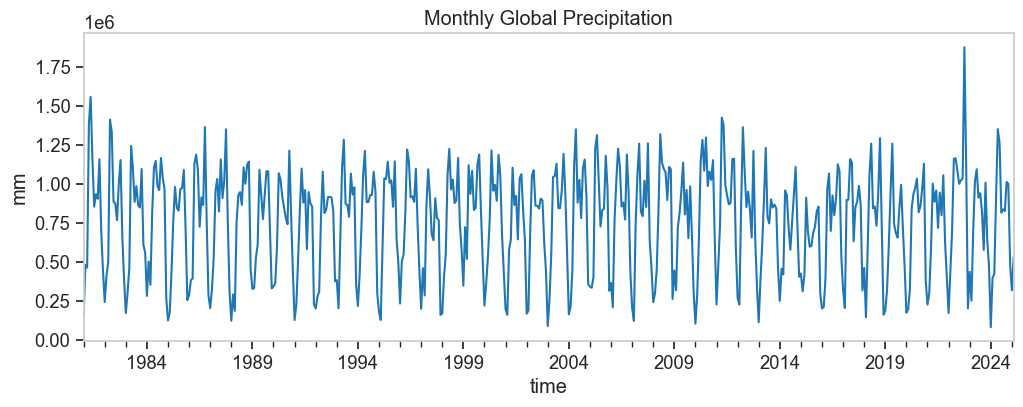

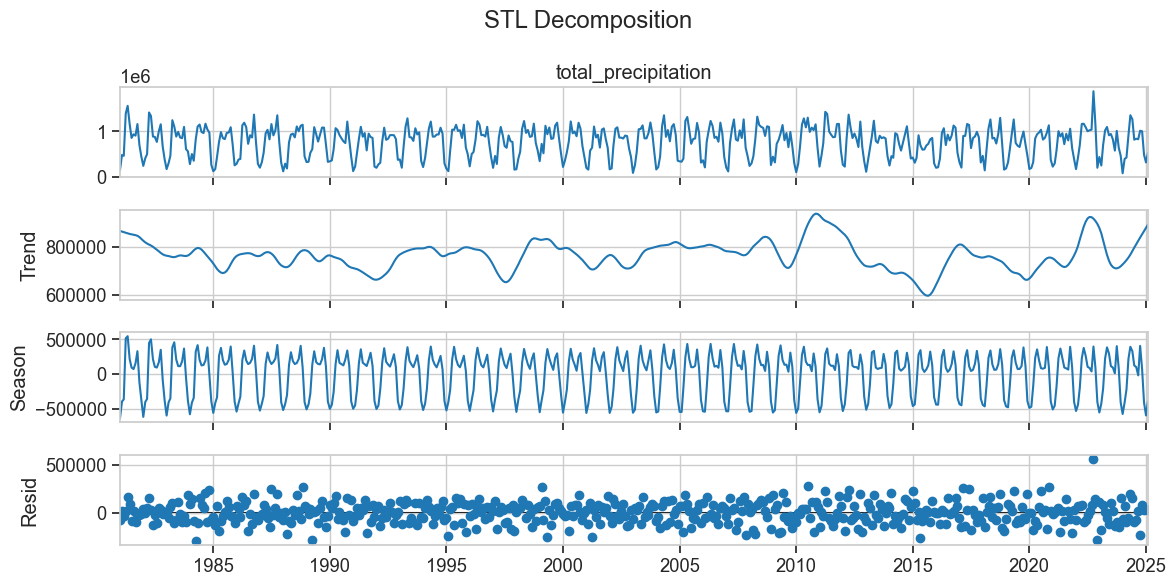

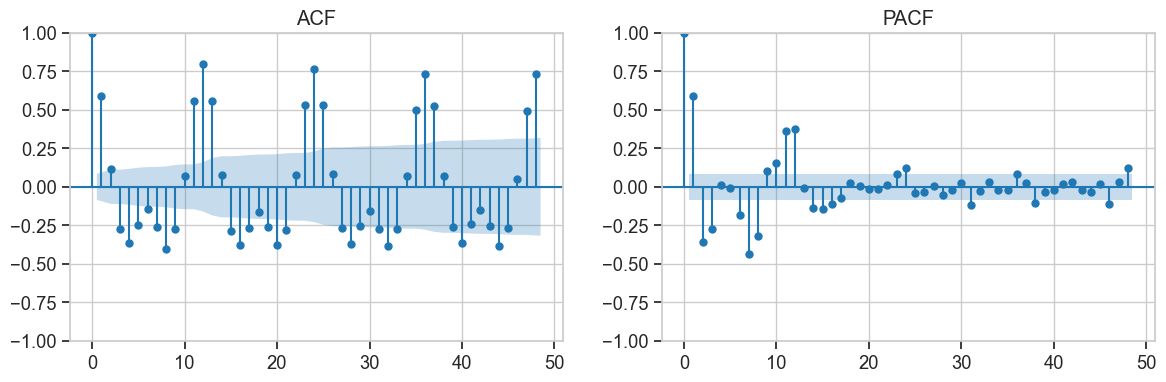

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.6302 - mae: 1.8948 - val_loss: 0.1585 - val_mae: 0.3533
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.6119 - mae: 1.2783 - val_loss: 0.1488 - val_mae: 0.3393
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.8813 - mae: 1.1197 - val_loss: 0.1421 - val_mae: 0.3304
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.6042 - mae: 0.9986 - val_loss: 0.1364 - val_mae: 0.3213
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.4605 - mae: 0.9277 - val_loss: 0.1314 - val_mae: 0.3152
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3516 - mae: 0.9227 - val_loss: 0.1298 - val_mae: 0.3125
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1452 - mae: 0.8772 - val_loss: 0.1276 - val_mae: 0.3099
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0935 - mae: 0.8360 - val_loss: 0.1250 - val_mae: 0.3064
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss

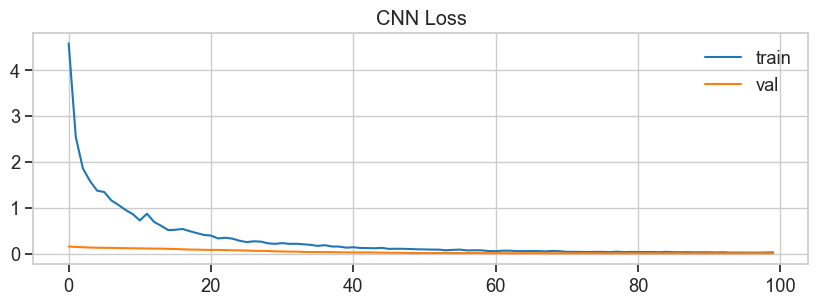

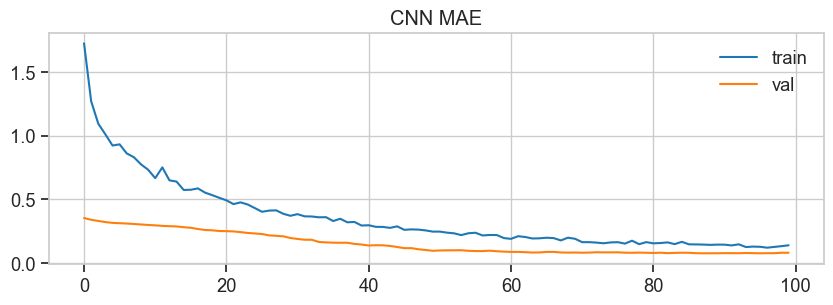

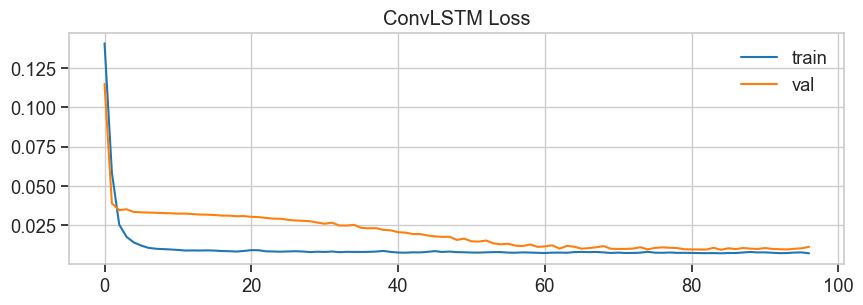

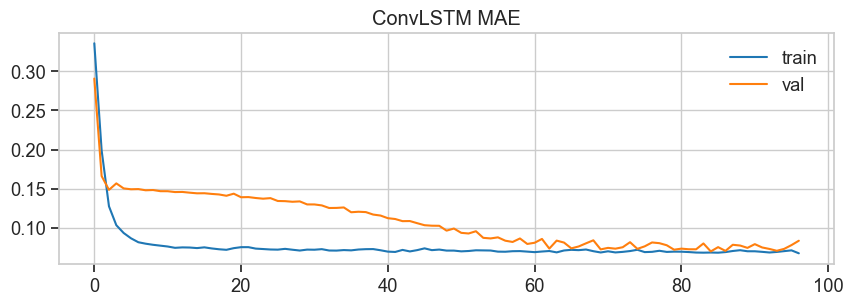


Comparative Metrics:


,MAE,RMSE,MAPE,Acc,R2
Model,,,,,
CNN,136722.734375,183072.394336,0.294192,0.705808,0.705765
ConvLSTM,125798.609375,174449.660453,0.243810,0.756190,0.732830


In [60]:
# GPU‐aware + RAM‐optimized pipeline con saneamiento de datos

import os
import gc
import psutil
import warnings

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error
)

import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    ConvLSTM2D,
    MaxPooling2D,
    BatchNormalization,
    Dropout,
    Flatten,
    Dense
)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

warnings.filterwarnings("ignore")

# 1) Configurar GPU y mixed precision (opcionales)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for g in gpus:
        tf.config.experimental.set_memory_growth(g, True)
    device = '/GPU:0'
    print("✅ GPU habilitada, memory_growth ON")
else:
    device = '/CPU:0'
    print("ℹ️ No se detectó GPU, usando CPU")

# Forzamos float32 para evitar problemas de dtype
mixed_precision.set_global_policy('float32')

# 2) Rutas y carga de datos
DATA_PATH  = data_file
MODEL_PATH = model_output_dir
os.makedirs(MODEL_PATH, exist_ok=True)

# Carga de la serie
ds     = xr.open_dataset(DATA_PATH)
precip = ds['total_precipitation'].sum(dim=['latitude','longitude']).to_series()

# 3) Visualización rápida
plt.figure(figsize=(12,4))
precip.plot(title='Monthly Global Precipitation')
plt.ylabel('mm'); plt.grid(); plt.show()

# 4) STL + ACF/PACF
res = STL(precip, seasonal=13).fit()
fig = res.plot(); fig.set_size_inches(12,6)
plt.suptitle('STL Decomposition'); plt.tight_layout(); plt.show()

fig, axes = plt.subplots(1,2,figsize=(14,4))
plot_acf(precip, lags=48, ax=axes[0]); axes[0].set_title('ACF')
plot_pacf(precip, lags=48, ax=axes[1]); axes[1].set_title('PACF')
plt.show()

# 5) Crear datos supervisados
def create_supervised(series, window):
    X, y = [], []
    for i in range(window, len(series)):
        X.append(series.iloc[i-window:i].values)
        y.append(series.iloc[i])
    return np.array(X), np.array(y)

WINDOW = 72
X, y = create_supervised(precip, WINDOW)
del precip; gc.collect()

# 6) Saneamiento de NaN/Inf
finite_max = np.nanmax(X[np.isfinite(X)])
finite_min = np.nanmin(X[np.isfinite(X)])
X = np.nan_to_num(X, nan=0.0, posinf=finite_max, neginf=finite_min)
y = np.nan_to_num(y, nan=0.0, posinf=np.nanmax(y), neginf=np.nanmin(y))

# 7) Escalado y split
split = int(0.8 * len(X))
sc_x = MinMaxScaler().fit(X.reshape(-1,1).astype(np.float32))
sc_y = MinMaxScaler().fit(y.reshape(-1,1).astype(np.float32))

X32 = sc_x.transform(X.reshape(-1,1).astype(np.float32)).reshape(-1, WINDOW, 1)
y32 = sc_y.transform(y.reshape(-1,1).astype(np.float32)).reshape(-1,1)

X_train, X_val = X32[:split], X32[split:]
y_train, y_val = y32[:split], y32[split:]

del X, y, X32, y32; gc.collect()

# 8) Preparar inputs para CNN y ConvLSTM
# CNN: [batch, H, W, C]
X_train_cnn = X_train[..., None]
X_val_cnn   = X_val[..., None]
# ConvLSTM: [batch, T, H, W, C], T=1
X_train_cl = X_train_cnn[:, None, ...]
X_val_cl   = X_val_cnn[:,   None, ...]

# 9) Definir arquitecturas
def build_cnn():
    m = Sequential([
        Input(shape=(WINDOW,1,1)),
        Conv2D(32,(3,3),activation='relu',padding='same'),
        BatchNormalization(),
        MaxPooling2D((2,1)),
        Dropout(0.25),
        Conv2D(64,(3,3),activation='relu',padding='same'),
        BatchNormalization(),
        MaxPooling2D((2,1)),
        Dropout(0.25),
        Conv2D(1,(1,1),activation='linear',padding='same'),
        Flatten(),
        Dense(1)
    ])
    m.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return m

def build_convlstm():
    m = Sequential([
        Input(shape=(1,WINDOW,1,1)),
        ConvLSTM2D(32,(3,3),padding='same',return_sequences=False),
        BatchNormalization(),
        Conv2D(1,(3,3),activation='linear',padding='same'),
        Flatten(),
        Dense(1)
    ])
    m.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return m

# 10) Callbacks (.keras nativo)
cb_cnn = [
    EarlyStopping('val_loss', patience=8, restore_best_weights=True),
    ModelCheckpoint(os.path.join(MODEL_PATH,'cnn_best.keras'), save_best_only=True)
]
cb_cl = [
    EarlyStopping('val_loss', patience=12, restore_best_weights=True),
    ModelCheckpoint(os.path.join(MODEL_PATH,'convlstm_best.keras'), save_best_only=True)
]

# 11) Entrenamiento
epochs = 100
batch  = 32
with tf.device(device):
    cnn    = build_cnn()
    hist_cnn = cnn.fit(
        X_train_cnn, y_train,
        validation_data=(X_val_cnn, y_val),
        epochs=epochs, batch_size=batch,
        callbacks=cb_cnn, verbose=1
    )
    K.clear_session(); gc.collect()

    cl     = build_convlstm()
    hist_cl = cl.fit(
        X_train_cl, y_train,
        validation_data=(X_val_cl, y_val),
        epochs=epochs, batch_size=batch,
        callbacks=cb_cl, verbose=1
    )

# 12) Plot history
def plot_history(h, name):
    plt.figure(figsize=(10,3))
    plt.plot(h.history['loss'], label='train')
    plt.plot(h.history['val_loss'], label='val')
    plt.title(f'{name} Loss'); plt.legend(); plt.show()
    plt.figure(figsize=(10,3))
    plt.plot(h.history['mae'], label='train')
    plt.plot(h.history['val_mae'], label='val')
    plt.title(f'{name} MAE'); plt.legend(); plt.show()

plot_history(hist_cnn,'CNN')
plot_history(hist_cl,'ConvLSTM')

# 13) Métricas finales
def inv_y(s): 
    return sc_y.inverse_transform(s).flatten()

rows = []
for name, model, X_in in [
    ('CNN',     cnn, X_val_cnn),
    ('ConvLSTM',cl, X_val_cl)
]:
    y_pred_s = model.predict(X_in, verbose=0)
    y_pred   = inv_y(y_pred_s)
    y_true   = inv_y(y_val)
    mae   = mean_absolute_error(y_true, y_pred)
    rmse  = np.sqrt(mean_squared_error(y_true, y_pred))
    mape  = mean_absolute_percentage_error(y_true, y_pred)
    acc   = 1 - mape
    r2    = r2_score(y_true, y_pred)
    rows.append({
        'Model': name,
        'MAE':   mae,
        'RMSE':  rmse,
        'MAPE':  mape,
        'Acc':   acc,
        'R2':    r2
    })

import pandas as pd
metrics_df = pd.DataFrame(rows).set_index('Model')
print("\nComparative Metrics:")
display(metrics_df)
